### Example Usage

In [1]:
%matplotlib inline

import xwavelet as xw
import xarray as xr
import matplotlib.pyplot as plt

Load an xarray timeseries data array of potential temperature, select the top level for SST, and remove the time mean.

In [2]:
dset = xr.open_mfdataset(
    "/Users/krasting/pp/ocean_Drake_Passage/ts/monthly/10yr/*.thetao.nc",
    use_cftime=True,
)

# select top level
sst = dset.thetao.isel(z_l=0)

# create area mean
sst = sst.mean(dim=("yh_sub01", "xh_sub01"))

# remove time mean
sst = sst - sst.mean(dim="time")

Use the wavelet analysis with the default settings.  Defaults are for the "Morlet" transform and a starting timescale of 6 months.

In [3]:
xw.wavelet(sst)

<xarray.DataArray 'thetao' (period: 29, time: 360)>
array([[ 0.43365389-1.01972320e+00j,  1.09841309-1.75720367e-01j,
         0.70159368+8.33944305e-01j, ..., -0.25928711+2.31846784e-01j,
        -0.26509361-1.63899100e-01j,  0.070888  -2.94952216e-01j],
       [ 0.26375124-9.72109901e-01j,  0.80718536-4.81524394e-01j,
         0.82010957+1.73000442e-01j, ...,  0.38012325-2.04160175e-01j,
         0.35551864+3.22878299e-02j,  0.24899452+1.81575082e-01j],
       [ 0.26534681-1.68468070e+00j,  1.26016944-1.24910403e+00j,
         1.81002396-2.79102846e-01j, ...,  0.47173001-1.12110622e+00j,
         0.96240617-5.85555829e-01j,  1.0310819 +8.17300404e-02j],
       ...,
       [ 0.90805973-1.52050364e+00j,  0.92665028-1.50924586e+00j,
         0.94510127-1.49776079e+00j, ..., -1.73320056-3.64032451e-01j,
        -1.72860281-3.85274077e-01j, -1.72374475-4.06457682e-01j],
       [ 0.19350438-3.24014047e-01j,  0.19746596-3.21615053e-01j,
         0.2013978 -3.19167625e-01j, ..., -0.36933902-7.75740515e-02j,
        -0.36835926-8.21005683e-02j, -0.36732402-8.66147210e-02j],
       [ 0.00382175-6.39934163e-03j,  0.00389999-6.35196102e-03j,
         0.00397765-6.30362383e-03j, ..., -0.00729452-1.53210289e-03j,
        -0.00727517-1.62150249e-03j, -0.00725472-1.71065790e-03j]])
Coordinates:
  * time     (time) object 0081-01-16 12:00:00 ... 0110-12-16 12:00:00
    z_l      float64 2.5
  * period   (period) float64 0.5 0.5946 0.7071 0.8409 ... 45.25 53.82 64.0

Plot the time-mean power spectrum

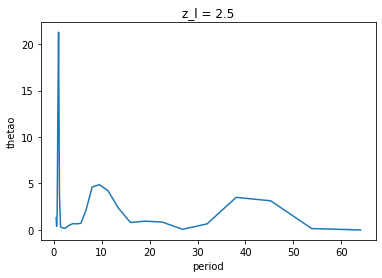

In [4]:
xw.power_spectrum(xw.wavelet(sst)).plot()